# Grover's Algorithm and Matched Filtering

Here we will consider trying to find the frequency of a sine wave signal from amongst a number of known frequencies when the signal start time and amplitudes are known. Time domain data $\mathcal{D}$ of length $N$ is taken from the signal and compared to $M$ templates $\mathcal{T}$ of sine waves of known frequencies equally spaced out in the frequency space of interest.

## Matched Filtering (just inner product)

In [1]:
# Import necessary packages
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# N is the number of data points
N = 1024
# M is the number of templates
M = int(2**(5))

In [3]:
# The signal is a sinosoid with a random frequency:
f_data = np.random.uniform(0.5,1.)
# The templates have frequencies spread uniformly over the desired range:
f_template = np.linspace(0.5,1.,M)

In [4]:
x=np.linspace(0.,1.,N)

# Noisless data samples and templates are produced
Data = np.sin(f_data*x*(2*np.pi))
Templates = np.sin(f_template*np.vstack(x)*(2*np.pi))

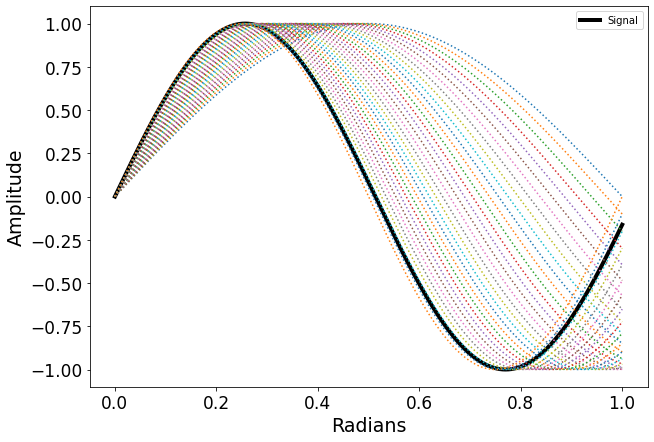

In [5]:
if M<1025:
    plt.figure(figsize=(10,7))
    plt.plot(x,Data,label='Signal',lw=4, color='black')
    plt.plot(x,Templates,ls=':')
    plt.xlabel('Radians')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.show()

**Figure:** The signal (black) is plotted against the templates (colored dotted).

I do not calculate SNR between the signal and templates (there is no noise yet) but instead just calculate the inner product and set a threshold value of $\overrightarrow{\mathcal{D}}\ \cdot\ \overrightarrow{\mathcal{T}}>0.999$ (maybe change this to selecting the location of maximum $\overrightarrow{\mathcal{D}}\ \cdot\ \overrightarrow{\mathcal{T}}$ to ensure there is only 1 matching template until *quantum counting* is implemented). The result from the inner product for each template is printed below:

In [6]:
# Calculating the norm of each vector
norm_T = np.linalg.norm(Templates,axis=0)
norm_D = np.linalg.norm(Data)

# Calculating the normalised inner product between data and templates
dot = np.dot(Data,Templates)/(norm_T*norm_D)
print(dot)

[0.0366219  0.08462766 0.13553953 0.18887788 0.2440071  0.3001631
 0.35650184 0.4121632  0.46633957 0.51833703 0.56761849 0.61382326
 0.65676344 0.69640228 0.73282157 0.76618554 0.79670637 0.82461462
 0.85013588 0.87347328 0.89479524 0.91422706 0.93184553 0.94767549
 0.96168801 0.97379978 0.98387393 0.99172256 0.99711156 0.99976843
 0.99939379 0.99567714]


# Grover's Algorithm

We assume there is only 1 matching template $\mathcal{T}_{0}$. Grover's algorithm is then applied as follows:

1. Create operator $\hat{U}_{w}=\mathcal{I}-2|w⟩⟨w|$ where $w$ is the matrix position corresponding to the template $\mathcal{T}_{0}$. This operator has the property:

$$ \hat{U}_{w} |x⟩ = -|x⟩ \text{ if } x=w, $$
$$ \hat{U}_{w} |x⟩ = |x⟩ \text{ if } x\ne w.\ \ \$$

2. Initiate superposition:

$$ |s⟩ = \frac{1}{\sqrt{M}}\sum^{M-1}_{x=0}|x⟩, $$

assuming that every template is equally likely to have the correct template without any more prior knowledge.

3. Create the Grover diffusion operator $\hat{U}_{s}=2|s⟩⟨s|-\mathcal{I}$.

4. Apply $\hat{U}_{w}$ then $\hat{U}_{s}$ to $|s⟩$.

5. Apply $\hat{U}_{w}$ then $\hat{U}_{s}$ to the result $\sqrt{M}$ times.

$\hat{U}_{w}$ can be created from the inner product threshold previously set:

In [7]:
diag = np.where(1-dot<1e-3,-1,1)
U_w = np.eye(M)*diag

In [8]:
k_T=(M-np.sum(diag))/2
print(str(k_T)+' match(es) to find!')

2.0 match(es) to find!


$\hat{U}_{w}$ =

In [9]:
print(U_w)

[[ 1.  0.  0. ... -0. -0.  0.]
 [ 0.  1.  0. ... -0. -0.  0.]
 [ 0.  0.  1. ... -0. -0.  0.]
 ...
 [ 0.  0.  0. ... -1. -0.  0.]
 [ 0.  0.  0. ... -0. -1.  0.]
 [ 0.  0.  0. ... -0. -0.  1.]]


This produces a diagonal matrix with 1s on the diagonal where the condition is not met and -1s where the condition is met (idealy there should only be one -1).

$|s⟩$ can be defined as so:

In [10]:
s_i = np.array([np.ones(M)/np.sqrt(M)]).T

$|s⟩=$

In [11]:
print(s_i.shape)

(32, 1)


and $\hat{U}_{s}$ can be made from this:

In [12]:
U_s = 2*np.outer(s_i,s_i)-np.eye(M)

$\hat{U}_{s}$ = 

In [13]:
print(U_s)

[[-0.9375  0.0625  0.0625 ...  0.0625  0.0625  0.0625]
 [ 0.0625 -0.9375  0.0625 ...  0.0625  0.0625  0.0625]
 [ 0.0625  0.0625 -0.9375 ...  0.0625  0.0625  0.0625]
 ...
 [ 0.0625  0.0625  0.0625 ... -0.9375  0.0625  0.0625]
 [ 0.0625  0.0625  0.0625 ...  0.0625 -0.9375  0.0625]
 [ 0.0625  0.0625  0.0625 ...  0.0625  0.0625 -0.9375]]


In [14]:
# Saving the initial state
s=s_i

# Initiating list to save max probabilities
ps=[]

# Looping through 2 x M^1/2 iterations
for i in range(2*int(np.sqrt(M))):
    # Applying U_w then U_s to s
    s = np.dot(np.matmul(U_s,U_w),s)
    pos=np.argmax(s**2)
    ps.append(s[pos][0]**2)
    print('Iteration '+str(i+1))
    print('Maximum probability of measuring state '+str(pos)+' with probability '+str(s[pos][0]**2)+'.')

ps=np.array(ps)
    
# Saving the final state
s_f = s

Iteration 1
Maximum probability of measuring state 29 with probability 0.23632812499999994.
Iteration 2
Maximum probability of measuring state 29 with probability 0.45422363281249983.
Iteration 3
Maximum probability of measuring state 29 with probability 0.48065948486328103.
Iteration 4
Maximum probability of measuring state 29 with probability 0.290852069854736.
Iteration 5
Maximum probability of measuring state 29 with probability 0.06274583935737593.
Iteration 6
Maximum probability of measuring state 16 with probability 0.03265397436916823.
Iteration 7
Maximum probability of measuring state 29 with probability 0.1824564441340041.
Iteration 8
Maximum probability of measuring state 29 with probability 0.4180445874299029.
Iteration 9
Maximum probability of measuring state 29 with probability 0.49609093001026705.
Iteration 10
Maximum probability of measuring state 29 with probability 0.34342702570600514.


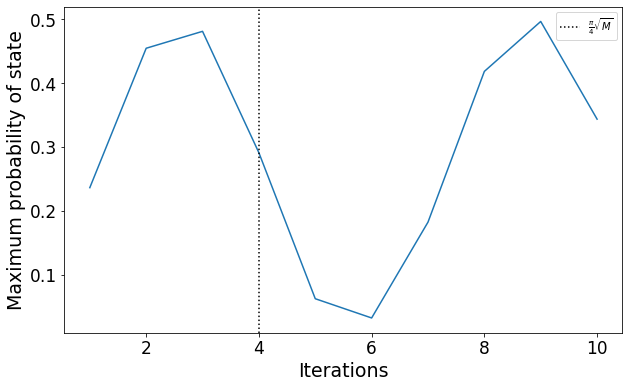

In [15]:
# Plotting the maximum measurement probability of the state over iterations
plt.figure(figsize=(10,6))
plt.plot(np.arange(1,len(ps)+1),ps)
plt.xlabel('Iterations')
plt.ylabel('Maximum probability of state')
plt.axvline(int(np.pi*np.sqrt(M)/4),0,1,ls=':',label=r'$\frac{\pi}{4}\sqrt{M}$',color='black')
plt.legend()
plt.show()

**Figure:** The probability value of the state with the maximum probability over iterations. This forms a sinusoid as we expected with peak at $\pi\sqrt{M}$ when there is only 1 match. With more than 1 match, the frequency increased and the amplitude decreases. 

### Comments

* When no templates match the state $|s⟩$ does not change and so every template can equally match (not useful).
* When more than 1 temple matches the correct state cannot be identified well.
* Number of iterations is important, as applying $\sqrt{M}$ seems to reduce the probability of getting the correct answer compared to the result a couple of iterations before.
* Things (on my little classical laptop) get very slow for $M>10^{3}$.

# Quantum Counting

Now why don't we try the same thing but with *quantum counting*. Quantum counting uses the *quantum fourier transform* to evaluate the periodicity of the function plotted above. The period is related to the number of solutions that Grover's algorithm must find. With the correct number of solutions, Grover's algorithm can be used to find the correct solutions.

First we choose a number $P$ which encapsulates 1 period of the above function:

In [16]:
# Number of states in ancillary register
P=2**7

Then we make the state

$$ |\psi_{0}⟩ = \frac{1}{\sqrt{PM}}\sum^{P-1}_{p=0}\sum^{M-1}_{m=0}|p⟩|m⟩. $$

This is equivalent of the state $|s⟩$ previously made, but $P$ times.

In [17]:
# Initial state of equal superposition across ancillas qubits and template qubits
psi_0 = (1./np.sqrt(P*M))*np.ones((P,M))

Now we apply Grover's algorithm itterably to this state such that:

$$ |\psi_{1}⟩ = \hat{C}_{G}|\psi_{0}⟩, $$

where $\hat{C}_{G}|p⟩\otimes |m⟩\rightarrow |p⟩\otimes (\hat{G})^{p}|m⟩$,

and $\hat{G}=\hat{U_{s}}\hat{U_{w}}$.

In [18]:
# Applying Grover's algorithm p times to the m states for each state in P
for p in np.arange(P):
    psi_0[p]=np.dot(np.linalg.matrix_power(np.matmul(U_s,U_w),p),psi_0[p])

psi_1=psi_0

We can see what this superposition looks like by plotting the amplitudes of the states over all qubits as done below.

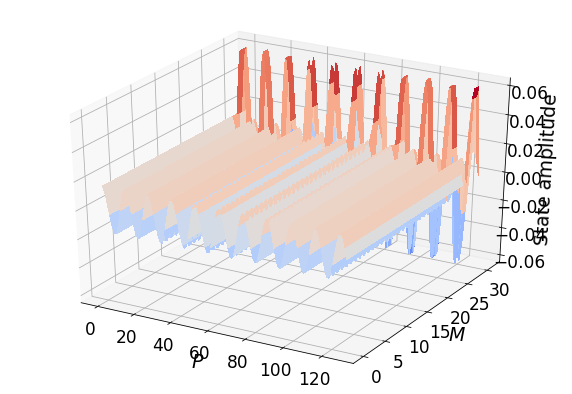

In [19]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

X=np.arange(P)
Y=np.arange(M)

X, Y = np.meshgrid(X, Y)
Z=psi_1.T
fig = plt.figure(figsize=(10,7))
ax = fig.gca(projection='3d')

surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

ax.set_xlabel(r'$P$')
ax.set_ylabel(r'$M$')
ax.set_zlabel('State amplitude')

plt.show()

Figure: Amplitudes of states $\psi_{1}$ numbering $P\times M$. The sinusoidal behaviour from before is clearly apparent, where the amplitudes of the states around correct solutions are much greater than the incorrect solutions. The incorrect solutions also exhibit a sinusoidal pattern. 

It is the frequency $f$ of this sinusoid that we wish to determine, as it is related to the number of correct template matches $k$ by:

$$ k = \sin^{2}\frac{f\pi}{P}. $$

Determining phase/frequency information from amplitudes of states requires a *quantum fourier transform*.

### Quantum Fourier Transform

The *quantum fourier transform* is much the same as it's classical counterpart but is performed on amplitude/phase information stored on the states of qubits. It transfers information stored in amplitudes in quantum states into phase information. There also exists the inverse quantum fourier transform for the reverse opperation.

The quantum fourier transform acting on state $|p⟩$ gives:

$$ \mathrm{QFT}:|x⟩ \mapsto \frac{1}{\sqrt{K}}\sum^{K-1}_{k=0}e^{2\pi i\frac{kx}{K}}|k⟩. $$

The inverse quantum fourier transform is applied across the ancillary qubits the recover the phase information from the sinusoidal behaviour in the states shown in the graph above. This requires creating a $QFT^{-1}$ operator of size $P\times P$, which we will call $\hat{F}_{P}$ as done below:

In [20]:
# Constructing the inverse fourier transform of size PxP
F_P = np.round(
        np.array([[(np.exp(-2.*i*j*1j*np.pi/P)) 
                   for j in np.arange(P)] 
                    for i in np.arange(P)]),1)*1./np.sqrt(P)

Applying this across the ancillary states in $|\psi_{1}⟩$:

$$ \psi_{2} = \hat{F}_{P}\psi_{1}. $$

In [21]:
psi_2=np.dot(F_P,psi_1)

Gives the required phase information. We can then measure the ancillary states to recover the frequncy of the sinusoid above, as well as the template states to recover the index of a correct template. This can be visualised by plotting the probability of each state as shown below:

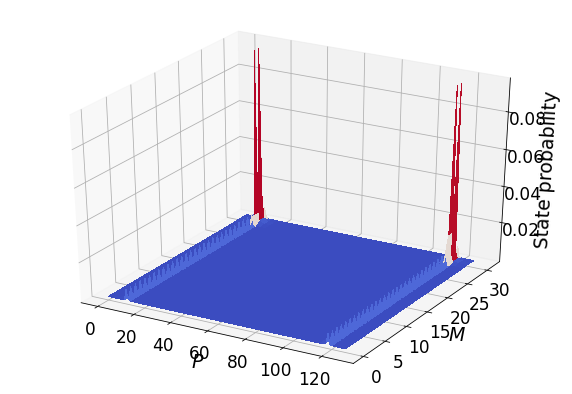

In [22]:
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
from matplotlib import cm

X=np.arange(P)
Y=np.arange(M)

X, Y = np.meshgrid(X, Y)
Z=np.absolute(psi_2).T**2
fig = plt.figure(figsize=(10,7))
ax = fig.gca(projection='3d')

surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

ax.set_xlabel(r'$P$')
ax.set_ylabel(r'$M$')
ax.set_zlabel('State probability')

plt.show()

Figure: The probabilities $|\psi_{2}|^{2}$ over ancillary and template states. Their are two peaks, corresponing to $f$ and $f-P$. Measuring the ancillary state will likeliy acquire one or the other. These peaks also correspond to the positions of matching templates, and so measuring the template qubits likely recovers a correct position of a template.

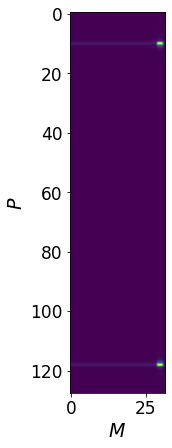

In [23]:
fig = plt.figure(figsize=(7, 7))

ax = fig.gca()
plt.imshow(np.absolute(psi_2)**2)
ax.set_xlabel('$M$')
ax.set_ylabel('$P$')
plt.show()

**Figure**: Same as the above figure but as a colour-map for easier viewing.

From knowing $f$ or $f-P$ we can work out the number of matched templates $k$ with the relation:

$$ k = \sin^{2}\frac{f\pi}{P}. $$

Doing this gives the number of matching templates for this example as:

In [24]:
f=np.argmax(np.absolute(psi_2)**2)/M
theta=f*np.pi/P
k=M*np.sin(theta)**2
print('Predicted number of matching templates is '+str(int(np.round(k))))
print('True number of matching templates is '+str(int(np.round(k_T))))

Predicted number of matching templates is 2
True number of matching templates is 2


The accuracy of this depends on $P$. 

The position of the correct template is found to be:

In [25]:
T_pred=np.argmax(np.absolute(psi_2)**2)%M
print('Correct template index is '+str(T_pred))

Correct template index is 29


In [26]:
f_pred=f_template[T_pred]
print('Predicted frequency is '+str(f_pred))
print('True frequency is '+str(f_data))

Predicted frequency is 0.967741935483871
True frequency is 0.9739656942301544
